### Import bibliotek ###

In [21]:
import os
import json
import string
import morfeusz2
import numpy as np
import pandas as pd
import operator as op
import itertools as it
from wordcloud import WordCloud
from matplotlib import pyplot as plt
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
from nltk.corpus import PlaintextCorpusReader
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.metrics.pairwise import cosine_distances, euclidean_distances
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

### Korpus dokumentów

In [2]:
corpus_dir = "./Literatura - original"
corpus = PlaintextCorpusReader(corpus_dir, ".*\.txt")
files_names = corpus.fileids()
files_names

['Harry Potter i Czara Ognia.txt',
 'Harry Potter i Insygnia Smierci.txt',
 'Harry Potter i Kamien Filozoficzny.txt',
 'Harry Potter i Komnata Tajemnic.txt',
 'Harry Potter i Ksiaze Polkrwi.txt',
 'Harry Potter i Przeklete Dziecko.txt',
 'Harry Potter i Wiezien Azkabanu.txt',
 'Harry Potter i Zakon Feniksa.txt',
 'Opowiesci z Narni. Kon i jego chlopiec.txt',
 'Opowiesci z Narni. Ksiaze Kaspian.txt',
 'Opowiesci z Narni. Lew, czarownica i stara szafa.txt',
 'Opowiesci z Narni. Ostatnia bitwa.txt',
 'Opowiesci z Narni. Podroz Wedrowca do Switu.txt',
 'Opowiesci z Narni. Siostrzeniec Czarodzieja.txt',
 'Opowiesci z Narni. Srebrne krzeslo.txt',
 'Zmierzch.Ksiezyc w Nowiu.txt',
 'Zmierzch.Przed Switem.txt',
 'Zmierzch.Zacmienie.txt',
 'Zmierzch.Zmierzch.txt',
 'Zmierzch.Zycie i Smierc.txt']

### Wstępne przygotowanie dokumentów

In [3]:
documents = {}
for file in files_names:
    documents[file] = corpus.raw(file)
print(json.dumps(documents, indent=4, ensure_ascii=False))

{
    "Harry Potter i Czara Ognia.txt": "Lord Voldemort, wraz ze swoim sługą Glizdogonem przybywa do domu należącego niegdyś do rodziny Riddle'ów położonego w Little Hangleton. Tam układają plan dotyczący zamordowania Harry'ego Pottera, co ma pomóc Czarnemu Panu w odzyskaniu jego dawnej mocy. Jest także mowa o wiernym słudze Czarnego Pana, który wkrótce ma znaleźć się w Hogwarcie. Wszystko to słyszy mieszkający nieopodal ogrodnik, Frank Bryce. Voldemort odkrywając, iż mężczyzna podsłuchuje, zaprasza go do środka i uśmierca. Harry budzi się z przerażającego snu. Jego blizna pulsuje okropnym bólem. Próbuje sobie przypomnieć o czym śnił, a z pamięci wyłania się obraz mrocznego pokoju, węża leżącego przed kominkiem oraz Glizdogona i Lorda Voldemorta planujących morderstwo. Harry zastanawia się czy powinien komuś powiedzieć o problemach z blizną, ponieważ, gdy bolała go ostatnim razem, Voldemort wdarł się do Hogwartu. Ostatecznie postanawia napisać do Syriusza i zejść na śniadanie. W trakci

In [4]:
stoplist_file = open("./stopwords_pl.txt", "r", encoding="UTF-8")
stoplist = stoplist_file.read().splitlines()
stoplist_file.close()
stoplist = stoplist[4:]
stoplist

['vol',
 'o.o.',
 'mgr',
 'godz',
 'zł',
 'www',
 'pl',
 'ul',
 'tel',
 'hab',
 'prof',
 'inż',
 'dr',
 'i',
 'u',
 'aby',
 'albo',
 'ale',
 'ani',
 'aż',
 'bardzo',
 'bez',
 'bo',
 'bowiem',
 'by',
 'byli',
 'bym',
 'był',
 'była',
 'było',
 'były',
 'być',
 'będzie',
 'będą',
 'chce',
 'choć',
 'co',
 'coraz',
 'coś',
 'czy',
 'czyli',
 'często',
 'dla',
 'do',
 'gdy',
 'gdyby',
 'gdyż',
 'gdzie',
 'go',
 'ich',
 'im',
 'inne',
 'iż',
 'ja',
 'jak',
 'jakie',
 'jako',
 'je',
 'jednak',
 'jednym',
 'jedynie',
 'jego',
 'jej',
 'jest',
 'jeszcze',
 'jeśli',
 'jeżeli',
 'już',
 'ją',
 'kiedy',
 'kilku',
 'kto',
 'która',
 'które',
 'którego',
 'której',
 'który',
 'których',
 'którym',
 'którzy',
 'lat',
 'lecz',
 'lub',
 'ma',
 'mają',
 'mamy',
 'mi',
 'miał',
 'mimo',
 'mnie',
 'mogą',
 'może',
 'można',
 'mu',
 'musi',
 'na',
 'nad',
 'nam',
 'nas',
 'nawet',
 'nic',
 'nich',
 'nie',
 'niej',
 'nim',
 'niż',
 'no',
 'nowe',
 'np',
 'nr',
 'o',
 'od',
 'ok',
 'on',
 'one',
 'oraz',
 '

In [10]:
def lemmatize(text):
    morf = morfeusz2.Morfeusz()
    segments = it.groupby(morf.analyse(text), op.itemgetter(0,1))
    def disambiguate(group):
        pairs = ((len(descr),lemma) 
                for _, _, (_, lemma, descr, _, _, ) in group)
        perpl, lemma = min(pairs)
        return lemma.split(":")[0]
    lemmas = (disambiguate(group) for key, group in segments)
    return " ".join(filter(str.isaplha, lemmas))

In [11]:
for key in documents:
    documents[key] = documents[key].lower()
    documents[key] = "".join([char for char in documents[key] if char not in string.punctuation])
    documents[key] = " ".join([word for word in word_tokenize(documents[key]) if word not in stoplist])
print(json.dumps(documents, indent=4, ensure_ascii=False))
    

{
    "Harry Potter i Czara Ognia.txt": "lord voldemort wraz swoim sługą glizdogonem przybywa domu należącego niegdyś rodziny riddleów położonego little hangleton układają plan dotyczący zamordowania harryego pottera pomóc czarnemu panu odzyskaniu dawnej mocy mowa wiernym słudze czarnego pana wkrótce znaleźć hogwarcie słyszy mieszkający nieopodal ogrodnik frank bryce voldemort odkrywając mężczyzna podsłuchuje zaprasza środka uśmierca harry budzi przerażającego snu blizna pulsuje okropnym bólem próbuje przypomnieć czym śnił a pamięci wyłania obraz mrocznego pokoju węża leżącego kominkiem glizdogona lorda voldemorta planujących morderstwo harry zastanawia powinien komuś powiedzieć problemach blizną bolała ostatnim razem voldemort wdarł hogwartu ostatecznie postanawia napisać syriusza zejść śniadanie trakcie śniadania wuj vernon otrzymuje list weasleyowie oferują zabranie harryego finał mistrzostw świata quidditchu ugoszczenie resztę wakacji długim namyśle użyciu harryego odpowiednich arg

In [12]:
morf = morfeusz2.Morfeusz()
morf.analyse("Ala ma kota")

[(0, 1, ('Ala', 'Ala', 'subst:sg:nom:f', ['imię'], [])),
 (0, 1, ('Ala', 'Al', 'subst:sg:gen.acc:m1', ['imię'], [])),
 (0, 1, ('Ala', 'Alo', 'subst:sg:gen.acc:m1', ['imię'], [])),
 (1, 2, ('ma', 'mój:A', 'adj:sg:nom.voc:f:pos', [], [])),
 (1, 2, ('ma', 'mieć', 'fin:sg:ter:imperf', [], [])),
 (2, 3, ('kota', 'kota', 'subst:sg:nom:f', ['nazwa_pospolita'], [])),
 (2,
  3,
  ('kota',
   'kot:Sm1',
   'subst:sg:gen.acc:m1',
   ['nazwa_pospolita'],
   ['pot.,środ.'])),
 (2, 3, ('kota', 'kot:Sm2', 'subst:sg:gen.acc:m2', ['nazwa_pospolita'], []))]

### Utworzenie macierzy częstości

In [13]:
docs = pd.DataFrame.from_dict(documents, orient = 'index')
docs.columns = ['content']
docs

,content
Harry Potter i Czara Ognia.txt,lord voldemort wraz swoim sługą glizdogonem pr...
Harry Potter i Insygnia Smierci.txt,podczas zebrania śmierciożerców odbywa dworze ...
Harry Potter i Kamien Filozoficzny.txt,ulicy privet drive pojawia stary człowiek dług...
Harry Potter i Komnata Tajemnic.txt,wuj vernon zły hedwiga robi bałagan domu tymcz...
Harry Potter i Ksiaze Polkrwi.txt,mugolskiego premiera odwiedza korneliusz knot ...
Harry Potter i Przeklete Dziecko.txt,scena pierwsza druga opowiada historię została...
Harry Potter i Wiezien Azkabanu.txt,harry leży kocami łóżku odrabia prace domowe z...
Harry Potter i Zakon Feniksa.txt,dudley zły wyżywa harrym dudley zostaje zaatak...
Opowiesci z Narni. Kon i jego chlopiec.txt,akcja książki rozgrywa narnii czasów panowania...
Opowiesci z Narni. Ksiaze Kaspian.txt,mija rok wydarzeń opisanych powieści lew czaro...


In [ ]:
count_vectorizer = CountVectorizer()
counts_tf = count_vectorizer.fit_transform(docs['content'])
counts_tf.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(20, 7360))

In [ ]:
tfidf_vectorizer = TfidfVectorizer()
counts_tfidf = tfidf_vectorizer.fit_transform(docs['content'])
counts_tfidf.toarray()

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.02005264, 0.02281262, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], shape=(20, 7360))

### Katalogi na wyniki

In [ ]:
if not os.path.exists("./wordclouds"):
    os.mkdir("./wordclouds")
if not os.path.exists("./topics"):
    os.mkdir("./topics")
if not os.path.exists("./clusters"):
    os.mkdir("./clusters")

### Chmury tagów

In [ ]:
wordcloud = WordCloud(
    background_color="white",
    max_words=5000,
    contour_width=3,
    contour_color="steelblue"
)

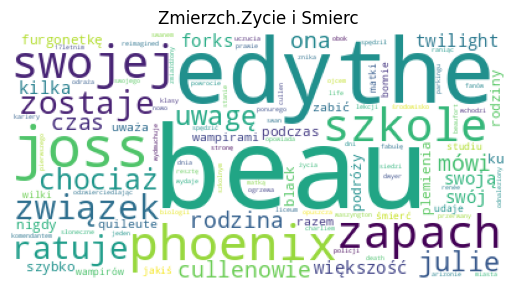

In [ ]:
for index, row in docs.iterrows():
    wordcloud.generate(row['content'])
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title(index.replace(".txt", ""))
    plt.savefig("./wordclouds/{}".format(index.replace(".txt",".png")))